## now when make evaluation, try includes future points

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
from collections import defaultdict
from itertools import product
from sklearn.metrics import mean_absolute_error as mae
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [155]:
look_back = 72
look_future = 36
# look_back = 15
# look_future = 5
# batch_size = 512
batch_size = 64
linear_node = 32

In [10]:
dat = pd.read_csv('train.csv', index_col='row_id')
def preprocess(dat):
    time_mapper = {}
    ii = 0
    for h in range(24):
        for mm in ['00','20','40']:
            hh = '{0:02d}'.format(h)
            time_mapper[hh+':'+mm] = ii
            ii += 1

    dat['unique'] = dat['x'].astype(str) + dat['y'].astype(str) + dat['direction']
    uniques = dat['unique'].unique()
    dat['day'] = pd.to_datetime(dat['time']).dt.weekday
    dat['time_stamp'] = dat['time'].apply(lambda x:time_mapper[x.split()[1][:5]])

    tmp = dat.groupby(['unique','day','time_stamp']).agg({'congestion':np.median})
    median_mapper = tmp.to_dict()['congestion']
    dat['median'] = dat.apply(lambda x: \
                              median_mapper[x['unique'],x['day'],x['time_stamp']], axis=1)
    dat['congestion-median'] = dat['congestion'] - dat['median']
    
    all_time = pd.DataFrame(pd.date_range('1991-04-01 00:00:00', '1991-09-30 11:40:00', freq='20Min'), columns=['time'])
    all_time['time'] = all_time['time'].astype(str)
    
    return uniques, median_mapper, time_mapper, all_time
uniques, median_mapper, time_mapper, all_time = preprocess(dat)

In [11]:
def getseries(unique):
    df = dat.loc[dat['unique']==unique, ['time', 'congestion-median']]
    df = pd.merge(all_time, df, left_on='time', right_on='time', how='outer')
    df = df.set_index('time')
    df['congestion-median'] = df['congestion-median'].fillna(0)
    ss = StandardScaler()
    df['congestion-median-normalized'] = ss.fit_transform(df['congestion-median'].values.reshape(-1,1)).reshape(-1)
    return df, ss

In [12]:
df,_ = getseries('00EB')

In [13]:
df

,congestion-median,congestion-median-normalized
time,,
1991-04-01 00:00:00,35.0,2.940104
1991-04-01 00:20:00,35.0,2.940104
1991-04-01 00:40:00,35.0,2.940104
1991-04-01 01:00:00,35.0,2.940104
1991-04-01 01:20:00,35.0,2.940104
...,...,...
1991-09-30 10:20:00,-7.0,-0.686983
1991-09-30 10:40:00,-6.0,-0.600624
1991-09-30 11:00:00,-7.0,-0.686983


In [14]:
test_periods = [
    ['1991-09-16 12:00:00', '1991-09-16 23:40:00'],
    ['1991-09-23 12:00:00', '1991-09-23 23:40:00']]
test_periods_with_lookback = []
for period in test_periods[:-1]:
    id1 = df.index.to_list().index(period[0])
    id1 = id1 - look_back
    id2 = df.index.to_list().index(period[1])
    print(id1, id2)

12060 12167


In [15]:
uniques

array(['00EB', '00NB', '00SB', '01EB', '01NB', '01SB', '01WB', '02EB',
       '02NB', '02SB', '02WB', '03EB', '03NB', '03NE', '03SB', '03SW',
       '03WB', '10EB', '10NB', '10NE', '10SB', '10SW', '10WB', '11EB',
       '11NB', '11SB', '11WB', '12EB', '12NB', '12NE', '12SB', '12SW',
       '12WB', '13EB', '13NB', '13NE', '13SB', '13SW', '13WB', '20EB',
       '20NB', '20SB', '20WB', '21EB', '21NB', '21NE', '21NW', '21SB',
       '21SE', '21SW', '21WB', '22EB', '22NB', '22NE', '22NW', '22SB',
       '22SE', '22SW', '22WB', '23EB', '23NB', '23NE', '23SB', '23SW',
       '23WB'], dtype=object)

In [50]:
# uniques_todo = ['00EB','10EB','10WB','20EB','20WB']
uniques_todo = uniques[:]

In [51]:
data_all = []
for unique in uniques_todo:
    df, ss = getseries(unique)
    print(f"{unique} mean={ss.mean_} std={ss.scale_}")
    data_all.append(df['congestion-median-normalized'].values)
data_all = np.array(data_all).T

00EB mean=[0.95494673] std=[11.57954203]
00NB mean=[0.36636225] std=[9.43834367]
00SB mean=[0.80989346] std=[12.66415534]
01EB mean=[0.31270928] std=[7.16000315]
01NB mean=[0.11331811] std=[6.53057596]
01SB mean=[0.12480974] std=[7.07213222]
01WB mean=[0.26012177] std=[10.8716075]
02EB mean=[0.12138508] std=[6.3123022]
02NB mean=[0.15669711] std=[6.25850326]
02SB mean=[0.2347793] std=[8.23555054]
02WB mean=[0.0956621] std=[5.89026848]
03EB mean=[0.32686454] std=[7.61781946]
03NB mean=[0.24101979] std=[5.89126285]
03NE mean=[0.51894977] std=[9.24724971]
03SB mean=[0.15015221] std=[8.23375089]
03SW mean=[0.37062405] std=[8.7385283]
03WB mean=[0.46803653] std=[8.50870973]
10EB mean=[0.02876712] std=[9.83829155]
10NB mean=[0.2587519] std=[10.99340554]
10NE mean=[0.04977169] std=[10.48097301]
10SB mean=[0.71438356] std=[10.07367299]
10SW mean=[0.45890411] std=[12.1627388]
10WB mean=[0.24847793] std=[6.42334036]
11EB mean=[0.24847793] std=[11.18812672]
11NB mean=[0.15989346] std=[10.31832783

In [52]:
np.mean(np.abs(data_all),axis=0)

array([0.74411232, 0.73272271, 0.68885603, 0.70650511, 0.70109617,
       0.67383517, 0.74960597, 0.68615763, 0.70872866, 0.72023099,
       0.54429618, 0.7098277 , 0.67608307, 0.68949218, 0.71140665,
       0.67762519, 0.70539177, 0.72957873, 0.75421574, 0.75001872,
       0.74256784, 0.77176702, 0.69730754, 0.75876791, 0.75820543,
       0.7566877 , 0.7562145 , 0.71014627, 0.74341657, 0.69780795,
       0.73006704, 0.67474084, 0.72678479, 0.69155535, 0.71405506,
       0.72714093, 0.71903352, 0.7073827 , 0.71462659, 0.74097749,
       0.63829302, 0.69517138, 0.73482825, 0.75306975, 0.65182169,
       0.54222884, 0.46384315, 0.61690899, 0.43455064, 0.48547183,
       0.75334959, 0.72349838, 0.72191201, 0.59598206, 0.56287097,
       0.69432433, 0.69414838, 0.55741912, 0.69573555, 0.74706284,
       0.6647803 , 0.59038589, 0.56141425, 0.62309218, 0.73535998])

In [21]:
data_all.shape

(13140, 5)

In [22]:
def create_dataset(dataset, look_back=72, look_future=36):
    ''' return shape (N,look_back,features), (N,look_future,features)'''
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_future+1):
        a = dataset[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(dataset[i+look_back:i+look_back+look_future,:])
    return np.array(dataX), np.array(dataY)

In [23]:
X, y = create_dataset(data_all[12060:12168])
X.shape, y.shape

((1, 72, 5), (1, 36, 5))

In [28]:
def assemble(dat):
    train_loaders, test_loaders = [], []
    
    # for train/test
    train = dat[:id1]
#     test = dat[id1:id1+look_back+look_future,icol]
    test = dat[id1:]
    print(train.shape, test.shape)

    X, y = create_dataset(train, look_back=look_back, look_future=look_future)
    train_dataset = []
    for i in range(len(X)):
        train_dataset.append((torch.tensor(X[i],dtype=torch.float32),
                              torch.tensor(y[i],dtype=torch.float32)))
    train_loaders.append(DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True))

    X, y = create_dataset(test, look_back=look_back, look_future=look_future)
    test_dataset = []
    for i in range(len(X)):
        test_dataset.append((torch.tensor(X[i],dtype=torch.float32),
                             torch.tensor(y[i],dtype=torch.float32)))
    test_loaders.append(DataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=True))
    
    train = dat[:]
    X, y = create_dataset(train, look_back=look_back, look_future=look_future)
    train_dataset = []
    for i in range(len(X)):
        train_dataset.append((torch.tensor(X[i],dtype=torch.float32),
                              torch.tensor(y[i],dtype=torch.float32)))
    train_loaders.append(DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True))
        
    return train_loaders, test_loaders

In [29]:
train_loaders, test_loaders = assemble(data_all)

(12060, 5) (1080, 5)


In [30]:
X, y = next(iter(test_loaders[0]))
X.shape, y.shape

(torch.Size([512, 72, 5]), torch.Size([512, 36, 5]))

In [45]:
nn.Dropout?

In [141]:
criterion = nn.L1Loss()
class MyModel(nn.Module):
    def __init__(self, input_feature, hidden_size, output_feature, num_layers=1):
        super(MyModel, self).__init__()
        self.linear = nn.Linear(input_feature, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, dropout=0.2)
        ''' 
            gru input is (L,N,H_in=H_hidden), hidden is (num_layers, h_hidden)
            output is (L,N,H_hidden), hidden is (num_layers, h_hidden)
        '''
        self.linear_out = nn.Linear(hidden_size, output_feature)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, input, hidden):
        ''' 
            input is in the shape of (L,N,input_feature) 
            output is (1,N,out_feature), the last time step
            hidden is (num_layers, h_hidden)
        '''
#         output = F.relu(self.linear(input))
        output = F.leaky_relu(self.linear(input))
        output = self.dropout(output)
        output, hidden = self.gru(output, hidden)
#         output = self.linear_out(F.relu(output[[-1]]))
        output = self.linear_out(F.leaky_relu(output[[-1]]))
        return output, hidden
    
    def initHidden(self, batch_size):
        return torch.zeros((self.num_layers, batch_size, self.hidden_size))

In [39]:
def evaluate(test_loader):
    model.eval()
    with torch.no_grad():
        
        curr_loss = 0
        
        for batch, (x, y) in enumerate(test_loader):
            
            N = len(x)
            x = x.transpose(0,1)
            y = y.transpose(0,1)
            
            hidden = model.initHidden(N)
            loss = 0
            output, hidden = model.forward(x, hidden)
            for idx in range(look_future):
                loss += criterion(output, y[[idx]])
                output, hidden = model.forward(output, hidden)
            loss /= look_future

            curr_loss += loss.item() * N
            
        curr_loss /= len(test_loader.dataset)
    return loss

In [54]:
def train(n_epoches, train_loader, test_loader):
    optimizer = optim.Adam(model.parameters())

    best_test_loss = 100.0
    for epoch in range(n_epoches):

        curr_loss = 0.0
        model.train()
        
        teacher = 0.05

        for batch, (x, y) in enumerate(train_loader):
            
            # turn into (L,N,H)
            N = len(x)
            x = x.transpose(0,1)
            y = y.transpose(0,1)
            
            hidden = model.initHidden(N)
            loss = 0
            output, hidden = model.forward(x, hidden)
            
            if np.random.random() > teacher:
                for idx in range(look_future):
                    loss += criterion(output, y[[idx]])
                    output, hidden = model.forward(output, hidden)
            else:
                for idx in range(look_future):
                    loss += criterion(output, y[[idx]])
                    output, hidden = model.forward(y[[idx]], hidden)
                    
            #print(output[-1,-1,:],y[-1])
            loss /= look_future
#             print(f"{batch} {loss}")

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            curr_loss += loss.item()*N

        curr_loss /= len(train_loader.dataset)
        
        test_loss = evaluate(test_loader)
        if (epoch % 1 == 0):  print(f'current {epoch} training loss={curr_loss} test loss = {test_loss}')
        if test_loss < best_test_loss:
            best_n_epoches = epoch + 1
            best_test_loss = test_loss
            print(f'updating best loss {epoch} training loss={curr_loss} test loss = {test_loss}')

        if epoch > best_n_epoches + 100:
            print('early stop')
            break
    return best_n_epoches

In [121]:
def retrain(n_epoches, train_loader):
    optimizer = optim.Adam(model.parameters())

    model.train()
    for epoch in range(n_epoches):
        
        curr_loss = 0.0
        teacher = 0.05
        
        for batch, (x, y) in enumerate(train_loader):
            N = len(x)
            x = x.transpose(0,1)
            y = y.transpose(0,1)
            
            hidden = model.initHidden(N)
            loss = 0
            output, hidden = model.forward(x, hidden)
            
            if np.random.random() > teacher:
                for idx in range(look_future):
                    loss += criterion(output, y[[idx]])
                    output, hidden = model.forward(output, hidden)
            else:
                for idx in range(look_future):
                    loss += criterion(output, y[[idx]])
                    output, hidden = model.forward(y[[idx]], hidden)
                    
            #print(output[-1,-1,:],y[-1])
            loss /= look_future
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            curr_loss += loss.item()*N

        curr_loss /= len(train_loader.dataset)
    return curr_loss

In [35]:
data_all[:,1]

array([ 2.5381676 ,  1.4200873 ,  0.302007  , ..., -0.81607331,
       -0.10456766, -0.20621132])

In [149]:
n_features = data_all.shape[1]

train_loaders, test_loaders = assemble(data_all)

model = MyModel(n_features, linear_node, n_features, num_layers=3)    
best_n_epoches = train(500, train_loaders[0], test_loaders[0])
torch.save({'best_epoches': best_n_epoches,
            'model': model.state_dict()},
            'model_pca_withforward_train_'+str(icol)+'.pickle')

model = MyModel(n_features, linear_node, n_features, num_layers=3)    
loss = retrain(best_n_epoches, train_loaders[1])
torch.save({'loss': loss,
            'best_epoches': best_n_epoches,
            'model': model.state_dict()},
            'model_pca_withforward_all_'+str(icol)+'.pickle')

(12060, 65) (1080, 65)
current 0 training loss=0.681249913317204 test loss = 0.6989095373364416
updating best loss 0 training loss=0.681249913317204 test loss = 0.6989095373364416
current 1 training loss=0.6726291537843349 test loss = 0.6947791603339294
updating best loss 1 training loss=0.6726291537843349 test loss = 0.6947791603339294
current 2 training loss=0.6711315623159878 test loss = 0.6940609418230949
updating best loss 2 training loss=0.6711315623159878 test loss = 0.6940609418230949
current 3 training loss=0.6708195280512137 test loss = 0.6939690774660806
updating best loss 3 training loss=0.6708195280512137 test loss = 0.6939690774660806
current 4 training loss=0.6706341812274131 test loss = 0.6937718098602217
updating best loss 4 training loss=0.6706341812274131 test loss = 0.6937718098602217
current 5 training loss=0.6702773670895692 test loss = 0.6928066637018602
updating best loss 5 training loss=0.6702773670895692 test loss = 0.6928066637018602
current 6 training loss=0

KeyboardInterrupt: 

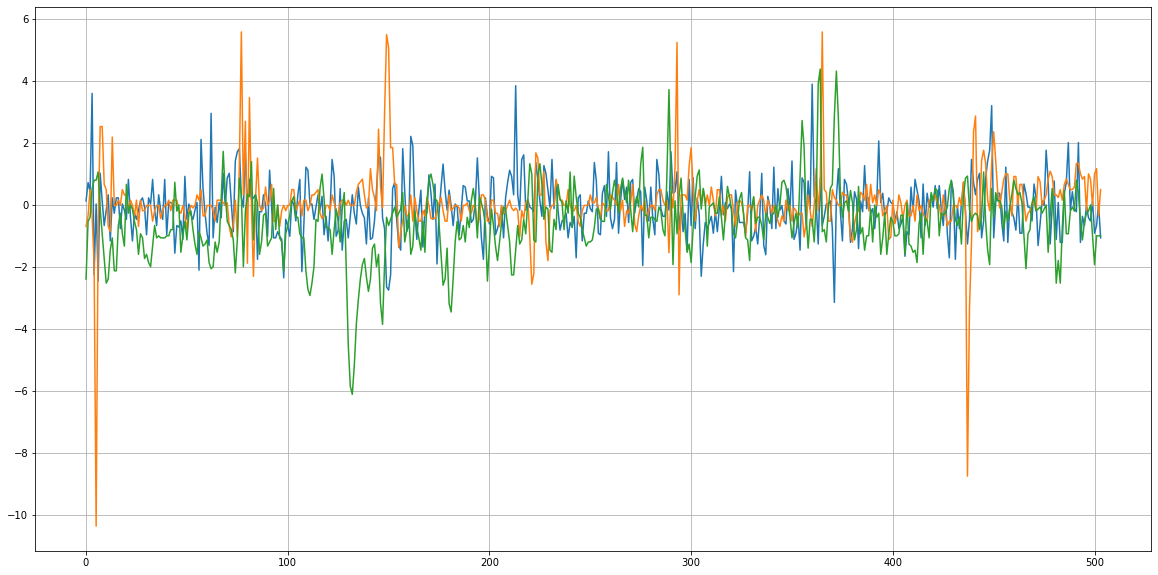

In [90]:
plt.figure(figsize=(20,10))
plt.plot(data_all[:72*7,20])
plt.plot(data_all[:72*7,10])
plt.plot(data_all[:72*7,30])
plt.grid()

In [79]:
data_all[:,0], data_all[:,1]

(array([ 2.94010361,  2.94010361,  2.94010361, ..., -0.68698284,
         0.52204597,  1.38563798]),
 array([ 2.0801995 ,  2.0801995 ,  2.0801995 , ..., -0.56857034,
         0.06713442,  0.17308522]))

In [86]:
np.sqrt(np.sum(np.power(data_all[:,0],2))), np.sqrt(np.sum((np.power(data_all[:,1],2))))

(114.62983904725681, 114.6298390472568)

In [88]:
np.convolve?

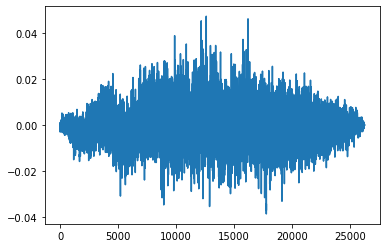

In [89]:
plt.plot(np.convolve(data_all[:,0],data_all[:,10])/114/114)

### how about adding time stamp as feature??

In [91]:
data_all.shape

(13140, 65)

In [92]:
data_all[:,66] = 0.0

IndexError: index 66 is out of bounds for axis 1 with size 65

In [96]:
df

,congestion-median,congestion-median-normalized
time,,
1991-04-01 00:00:00,-8.0,-0.778084
1991-04-01 00:20:00,23.0,2.153930
1991-04-01 00:40:00,6.0,0.546051
1991-04-01 01:00:00,0.0,-0.021436
1991-04-01 01:20:00,0.0,-0.021436
...,...,...
1991-09-30 10:20:00,14.0,1.302700
1991-09-30 10:40:00,6.0,0.546051
1991-09-30 11:00:00,-10.0,-0.967247


In [106]:
stamped = (np.array(range(data_all.shape[0])) % 72).reshape(-1,1)
stamped = (stamped - 36.0) / 72.0
stamped

array([[-0.5       ],
       [-0.48611111],
       [-0.47222222],
       ...,
       [-0.04166667],
       [-0.02777778],
       [-0.01388889]])

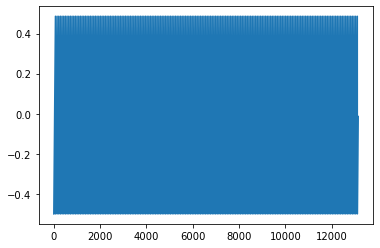

In [107]:
plt.plot(stamped)

In [108]:
data_all_stamped = np.hstack((data_all,stamped))

In [145]:
def evaluate(test_loader):
    model.eval()
    with torch.no_grad():
        
        curr_loss = 0
        
        for batch, (x, y) in enumerate(test_loader):
            
            N = len(x)
            x = x.transpose(0,1)
            y = y.transpose(0,1)
            
            hidden = model.initHidden(N)
            loss = 0
            output, hidden = model.forward(x, hidden)
            for idx in range(look_future):
                loss += criterion(output[:,:,:-1], y[[idx],:,:-1])
                output, hidden = model.forward(output, hidden)
            loss /= look_future

            curr_loss += loss.item() * N
            
        curr_loss /= len(test_loader.dataset)
    return curr_loss

In [119]:
def train(n_epoches, train_loader, test_loader):
    optimizer = optim.Adam(model.parameters())

    best_test_loss = 100.0
    train_losses = []
    test_losses = []
    
    for epoch in range(n_epoches):

        curr_loss = 0.0
        model.train()
        
        teacher = 0.05

        for batch, (x, y) in enumerate(train_loader):
            
            # turn into (L,N,H)
            N = len(x)
            x = x.transpose(0,1)
            y = y.transpose(0,1)
            
            hidden = model.initHidden(N)
            loss = 0
            output, hidden = model.forward(x, hidden)
            
            if np.random.random() > teacher:
                for idx in range(look_future):
                    loss += criterion(output[:,:,:-1], y[[idx],:,:-1])
                    output, hidden = model.forward(output, hidden)
            else:
                for idx in range(look_future):
                    loss += criterion(output[:,:,:-1], y[[idx],:,:-1])
                    output, hidden = model.forward(y[[idx]], hidden)
                    
            #print(output[-1,-1,:],y[-1])
            loss /= look_future
#             print(f"{batch} {loss}")

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            curr_loss += loss.item()*N

        curr_loss /= len(train_loader.dataset)
        
        test_loss = evaluate(test_loader)
        if (epoch % 1 == 0):  print(f'current {epoch} training loss={curr_loss} test loss = {test_loss}')
        if test_loss < best_test_loss and test_loss > curr_loss:
            best_n_epoches = epoch + 1
            best_test_loss = test_loss
            print(f'updating best loss {epoch} training loss={curr_loss} test loss = {test_loss}')
            
        train_losses.append(curr_loss)
        test_losses.append(test_loss)
        
        if epoch > 10 and epoch > best_n_epoches + 100:
            print('early stop')
            break
    return best_n_epoches, train_losses, test_losses

In [156]:
n_features = data_all_stamped.shape[1]

train_loaders, test_loaders = assemble(data_all_stamped)

model = MyModel(n_features, linear_node, n_features, num_layers=3)    
best_n_epoches, train_losses, test_losses = train(500, train_loaders[0], test_loaders[0])
torch.save({'best_epoches': best_n_epoches,
            'model': model.state_dict()},
            'model_allatonce_gru_withforward_train.pickle')


(12060, 66) (1080, 66)
current 0 training loss=0.6733238556430319 test loss = 0.6935515597324822
updating best loss 0 training loss=0.6733238556430319 test loss = 0.6935515597324822
current 1 training loss=0.6697036969225885 test loss = 0.6925510055972273
updating best loss 1 training loss=0.6697036969225885 test loss = 0.6925510055972273
current 2 training loss=0.6683324373666985 test loss = 0.6935813983812361
current 3 training loss=0.6670312971028785 test loss = 0.6949081888914354
current 4 training loss=0.6656334610860198 test loss = 0.6954421337927478
current 5 training loss=0.6642460671716242 test loss = 0.6998595309282011
current 6 training loss=0.6634496419208176 test loss = 0.6968502615485628
current 7 training loss=0.6628742314607721 test loss = 0.699824614735571
current 8 training loss=0.6620920689985821 test loss = 0.6981629304748644
current 9 training loss=0.6614854578282517 test loss = 0.698077024070724
current 10 training loss=0.6608033711008873 test loss = 0.69926690981

this is with look_back=15 look_future=5 batch_size=512

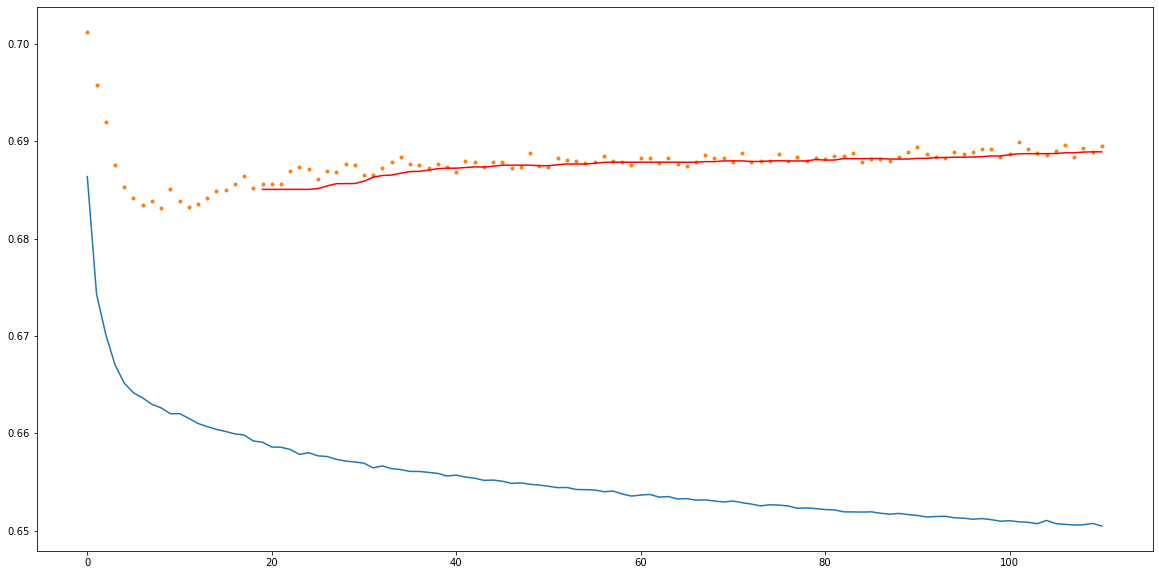

In [147]:
plt.figure(figsize=(20,10))
plt.plot(train_losses)
plt.plot(test_losses,'.')
plt.plot(pd.Series(test_losses).rolling(20).median(),'-r')

this is with look_back=72 look_future=36 batch_size=512

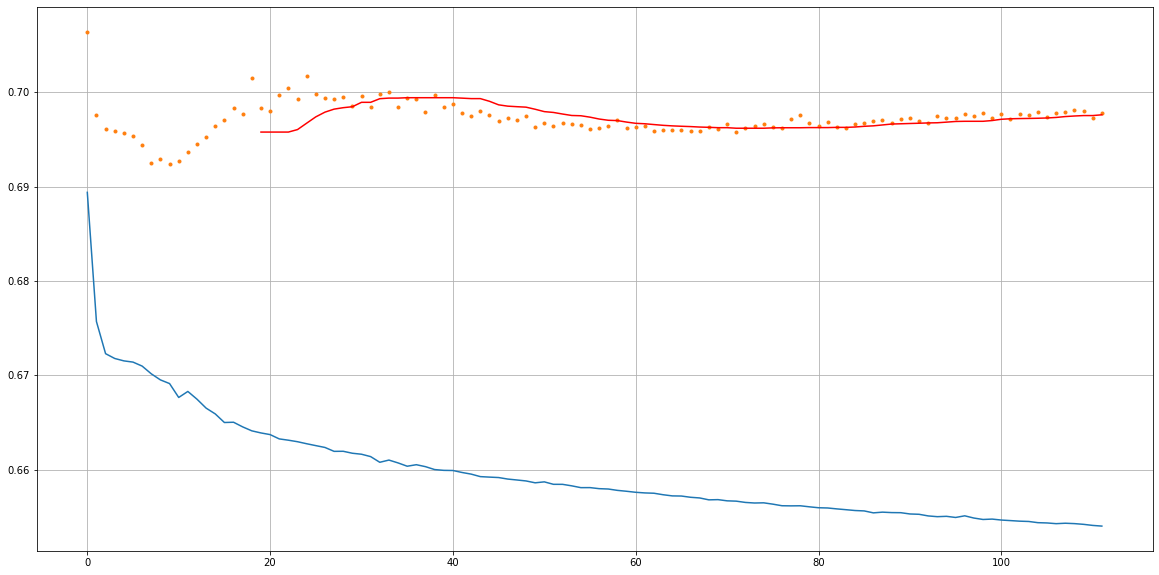

In [151]:
plt.figure(figsize=(20,10))
plt.plot(train_losses)
plt.plot(test_losses,'.')
plt.plot(pd.Series(test_losses).rolling(20).median(),'-r')
plt.grid()

this is with look_back=72 look_future=36 batch_size=1024

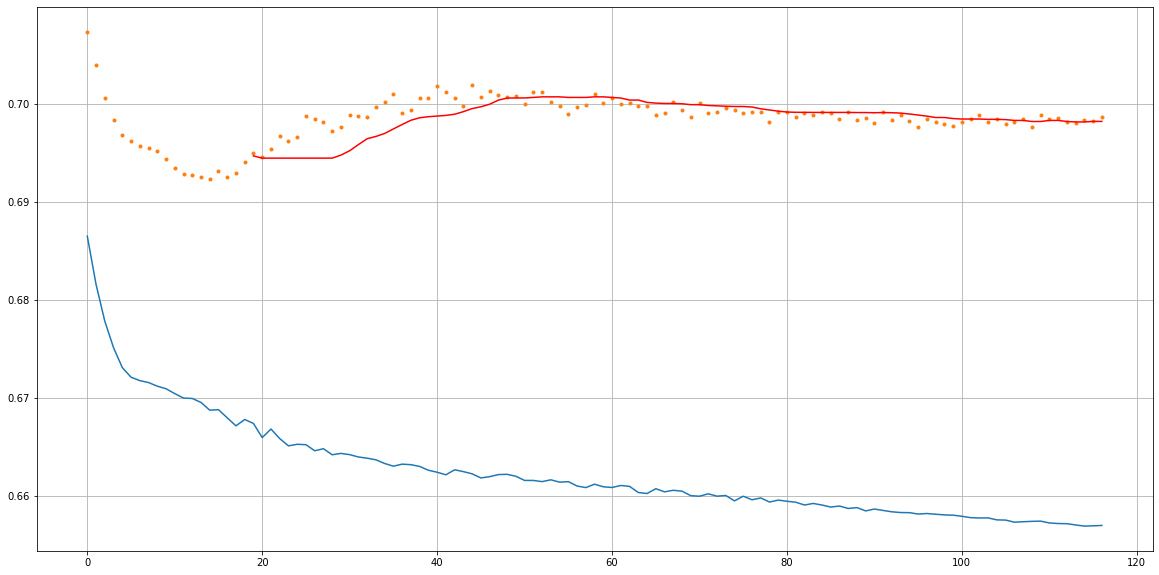

In [154]:
plt.figure(figsize=(20,10))
plt.plot(train_losses)
plt.plot(test_losses,'.')
plt.plot(pd.Series(test_losses).rolling(20).median(),'-r')
plt.grid()

this is with look_back=72 look_future=36 batch_size=64

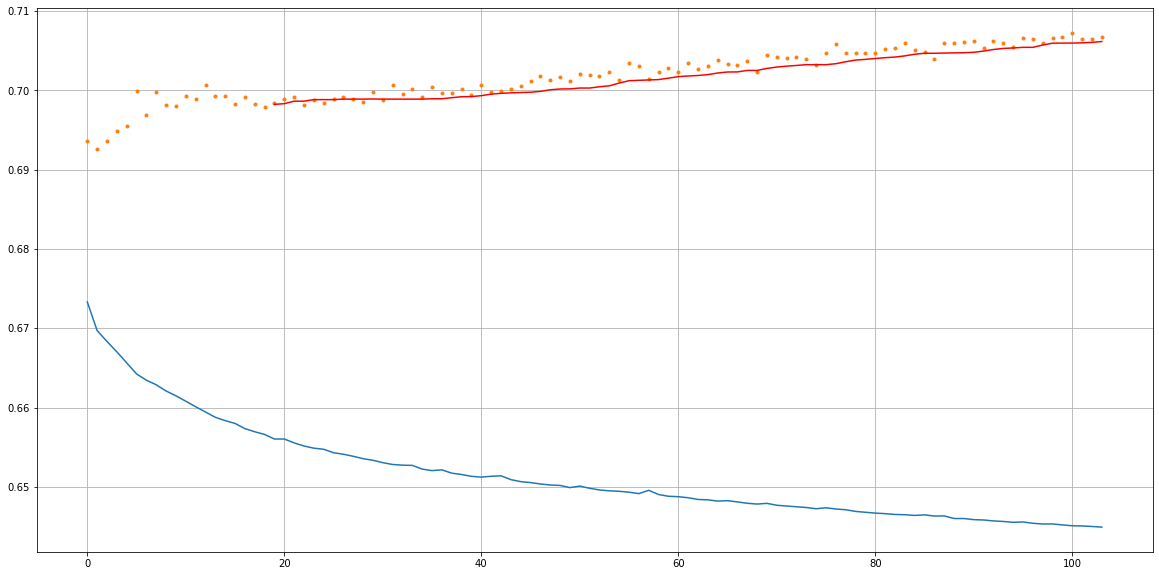

In [157]:
plt.figure(figsize=(20,10))
plt.plot(train_losses)
plt.plot(test_losses,'.')
plt.plot(pd.Series(test_losses).rolling(20).median(),'-r')
plt.grid()